In [1]:
import SL_sim as sls
import lenstronomy.Util.util as util
from astropy.io import fits
import pandas as pd
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
import numpy as np
import matplotlib.pyplot as plt
import random

# DES Simulations

This simulation toolbox is based on Lenstronomy [Birrer & Amara 2018](https://ui.adsabs.harvard.edu/abs/2018PDU....22..189B/abstract) python package and produce simulations built on real data.  In this notebook is presented an example about how this toolbox works to create DES simulations. 

The sources are gri-HSC ultra-deep stacks images combined with HST F814W high resolution images, more details about how they were obtained see [Canameras et al. (2020)](https://www.aanda.org/articles/aa/pdf/2020/12/aa38219-20.pdf)

The lenses in this example are LRGs from the Dark Energy Survey. 

These simulations were created to be used in **Rojas et al. in prep.**  

In [2]:
path_lens= 'lens/' #folder with DES images
path_lenspsf = 'lensPSF/' #folder with DES PSF for each image
path_source = 'sources/' #foler with HSC-HST images

## catalog Match lens + source

This is a small example of the catalog with the match of a lens and a source galaxy as explained in **Rojas et al. in prep.** 

I will use this catalog to leave available 10 different examples of simulations, but I selected object index=1 for the following steps, you can modify j = index to see other simulation examples. 

In [3]:
df = pd.read_csv('sim.csv')
df

,Unnamed: 0,Source_ID,source_ra,source_dec,source_z,source_object_id,source_mag_g,source_mag_r,source_mag_i,lens_ra,lens_dec,lens_mag_i,lens_mag_r,lens_mag_g,lens_vdisp,lens_z,lens_id,Theta_E,lens_vdisp_ori
0,3924,20148878,150.228457,2.508812,3.4236,43158605939081248,24.025421,23.018707,22.768764,7.992180,-49.123837,19.3570,19.8794,21.3493,295.867712,0.300929,1774311,2.072241,211.334080
1,6926,20040630,150.033324,1.881196,2.6397,43158726198200600,23.613653,23.034534,22.935276,332.168403,-42.062532,20.3911,21.1931,23.1122,345.046448,0.477023,23153409,2.387844,215.654030
2,944,20045249,149.838525,1.829022,4.2924,43158863637122696,25.395998,23.655254,23.020554,54.942706,-26.684532,20.3757,21.4027,23.1143,255.483569,0.555588,13065122,1.350638,232.257790
3,430,20136670,150.597216,2.615907,2.4500,43158331061208016,23.659716,23.396814,23.327503,49.021827,-19.995422,20.9299,21.5592,23.3102,246.728269,0.440841,11406730,1.237963,205.606891
4,6214,20165854,150.710214,2.638392,2.8335,43158331061181008,22.836891,22.364498,22.023455,66.193983,-44.826430,19.3092,19.8696,21.5130,322.120734,0.343534,16284248,2.334520,247.785180
5,8612,20020193,149.789763,1.723293,4.1732,43158859342187984,25.550716,23.940237,23.338486,20.778617,-36.285776,20.8721,22.0022,23.9861,375.009664,0.665690,4531139,2.709722,234.381040
6,9133,20135261,150.713584,2.561015,3.4000,43158331061202096,24.742836,23.657148,23.483570,96.545578,-59.697948,19.5306,20.1862,21.7913,350.069115,0.330878,19930460,2.841500,233.379410
7,9890,20007944,150.474618,1.753432,1.9602,43158447025331552,23.421949,23.249508,23.197042,358.425410,-38.742272,19.4374,20.0356,21.7754,376.597360,0.353315,24918571,2.976363,235.373350
8,5725,20135261,150.713584,2.561015,3.4000,43158331061202096,24.742836,23.657148,23.483570,11.426052,-48.559443,20.9024,22.0605,24.0310,344.668012,0.643288,4175568,2.226571,265.129240
9,6986,20059417,150.442032,2.000879,2.5074,43158455615254704,23.640465,23.317780,23.322361,12.439786,-21.916298,19.8233,20.5269,22.2380,338.147776,0.411738,2743489,2.392843,211.342360


In [4]:
j = 1 #select an object

## General setup

We need to setup some general things like:
1. **The bands to be simulated.** In general will depend on the data but 3 bands and single bands have been tested and both works well.
2. **Einstein radii**. This value will be an input for the model, in case you don't have the value beforehand in your csv file you can use Lenscosmo(z_l,z_s).sis_sigma_v2theta_E(vdisp) class from Lenstronomy.

In [5]:
bands=['g','r','i'] #band to simulate
src_z = df['source_z'].iloc[j] #redshift of the source obtained from the catalog
lens_z = df['lens_z'].iloc[j]
vdisp = df['lens_vdisp'].iloc[j]
theta_E = LensCosmo(lens_z,src_z).sis_sigma_v2theta_E(vdisp)
print(theta_E)

2.387843508338813


## Source setup

### Lenstronomy setup needed
We need to setup some characteristics of the source image observations, to perform some steps but in this case the information provide it here will not deeply affect the simulation process because we will use all the time the real image and we never will reconstruct it from parameters but better not mess with this and setup as much realistic as possible.

### opening fits files
All the source images are a data cube containing gri-bands.
I'm using astropy to open the fits file and assigning the arrays to individuals variables. 

### Source definitions for each band 
In this dictionary I'm defining several things that will be needed along the process of simulation:
1. **image:** numpy array 
2. **deltapix:** pixel size of the image
3. **zero_point:** of the corresponding survey
4. **HR_factor:** In case we want to increase the resolution of the source image by a factor. 
5. **psf:** psf array
6. **magnitude:** of the object in the corresponding band.

In [6]:
zp_src_t=27 #zero point of the survey
boost_mag = 0.8 #in case features are too weak this param allow a boost in the source magnitude


#lenstronomy setup needed:
camera = {'read_noise': 1,'pixel_scale': 0.03,'ccd_gain': 400}
band_obs = {'exposure_time': 0.,  # exposure time per image (in seconds)
            'sky_brightness': 0,  # sky brightness (in magnitude per square arcseconds)
            'magnitude_zero_point': zp_src_t,  
            'num_exposures': 0,  # number of exposures that are combined
            'seeing': 0.01,  # full width at half maximum of the PSF (if not specific psf_model is specified)
            'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
            'kernel_point_source': None # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }#SAME FOR THE 3 BANDS BECAUSE IS NOT NEEDED ANY OTHER SPECIFIC 

kwargs_data_src = util.merge_dicts(camera,band_obs) 

#opening fits data
HST_data= fits.open(path_source+'SOURCE'+str(df['Source_ID'].iloc[j])+'.fits')
HST_G,HST_R,HST_I = HST_data[0].data,HST_data[1].data,HST_data[2].data

#source definitions for each band
source_info_G = {'image':HST_G ,'deltapix': 0.03, 'zero_point': zp_src_t, 'HR_factor': 1,'magnitude':df['source_mag_g'].iloc[j]-boost_mag}
source_info_R = {'image':HST_R ,'deltapix': 0.03, 'zero_point': zp_src_t, 'HR_factor': 1,'magnitude':df['source_mag_r'].iloc[j]-boost_mag}
source_info_I = {'image':HST_I ,'deltapix': 0.03, 'zero_point': zp_src_t, 'HR_factor': 1,'magnitude':df['source_mag_i'].iloc[j]-boost_mag}


## Lens setup

For the lens data we have to:

**Open data file and its respective PSF**
**lens data definitions for each band:**
1. **deltapix:** pixel size of the image
2. **zero_point:** of the corresponding survey
3. **image:** numpy array
4. **psf:** numpy array

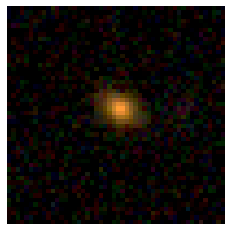

In [7]:
#opening fits data
DES_data= fits.open(path_lens+'DES_'+str(df['lens_id'].iloc[j])+'.fits')
DES_g,DES_r,DES_i = DES_data[0].data,DES_data[1].data,DES_data[2].data

#opening fits PSF data
psf_data= fits.open(path_lenspsf+'DES_PSF'+str(df['lens_id'].iloc[j])+'.fits')
psf_g,psf_r,psf_i = psf_data[0].data,psf_data[1].data,psf_data[2].data

#lens data definition for each band
deltapix_L = 0.27
zero_point_L = 30.0
lens_info_g = {'deltapix' : deltapix_L, 'zero_point': zero_point_L,'image':DES_g,'psf':psf_g}
lens_info_r = {'deltapix' : deltapix_L, 'zero_point': zero_point_L,'image':DES_r,'psf':psf_r}
lens_info_i = {'deltapix' : deltapix_L, 'zero_point': zero_point_L,'image':DES_i,'psf':psf_i}

#plot of the image selected
img_lens=sls.showplot_rgb(DES_i,DES_r,DES_g)
plt.imshow(img_lens,origin='lower')
plt.axis(False)
plt.show()

## Simulation procedure

Two more things to define before start with the simulations:

**src_pos_box = [min_x,max_x,min_y,max_y]** is to define a box around the caustic curve to select a random position of the source. The 4 different values are selected inside the code, but this 4 values here allow the possibility to do a bigger box depending on the value you choose if you min_x = 0 means there is no any increment in the size of the box but if min_x = 0.2 the box will be larger by a 20% in this direction.

**random.seed()** In order to obtain the same random values is possible to fix the random seed with a value otherwise comment or setup 'None'

**Lensmodel**
In this step we set up all the parameters for an SIE model ($\theta_{E}$,e1,e2,x1,x2). The Einstein radii ($\theta_{E}$) is already given, and the ellipticity (e1,e2) and central position (x1,x2) are estimated by fitting an elliptical Sersic profile to the image of the LRG. 

sls.make_lensmodel input params are:
- lens_info : dictionary with lens info (deltapix, zeropoint, image and PSF).
- theta_E : Einstein radii
- source_info: dictionary with source info (image, deltapix, zero_point, HR_factor, psf , magnitude)
- box_f: [min_x,max_x,min_y,max_y] 

sls.make_lensmodel() output a dictionary with the following information:
- 'lens_light_model_list', 'kwargs_light_lens', 'lens_light_model_class', 'kwargs_lens_list', 'kwargs_data_lens', 'image_data', 'source_shift'

In [8]:
src_pos_box = [0.0,0.0,0.0,0.0]
random.seed('22')

#lensmodel
LLM = sls.make_lensmodel(lens_info_r,theta_E,source_info_R,src_pos_box)

Computing the PSO ...
10
20
30
40
50
max iteration reached! stoping
-1.5894289047932044 reduced X^2 of best position
-1981.2231298247293 logL
2493.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.22272671076372438, 'n_sersic': 4.098233013625402, 'e1': 0.3069467358228678, 'e2': -0.4521504887909979, 'center_x': 0.2927376803668202, 'center_y': 0.3735279396012546}] lens light result
[] point source result
{} special param result
2.19344425201416 time used for  PSO
-1.5849785038597834 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.5803177654777105


Using the lensmodel created and saved in LLM we run the simulation step using **sls.make_lens_system()**
The inputs are:
- LLM dictionary, camera, source_info for the corresponding band, kwargs_data_src, lens_info for the corresponding band

The output is a dictionary that contains several arrays with images at the different stages and the final simulation under the name 'simulation'

In [9]:
MLS_G = sls.make_lens_sys(LLM,camera,source_info_G,kwargs_data_src,lens_info_g)
MLS_R = sls.make_lens_sys(LLM,camera,source_info_R,kwargs_data_src,lens_info_r)
MLS_I = sls.make_lens_sys(LLM,camera,source_info_I,kwargs_data_src,lens_info_i)

/home/karina/miniconda3/envs/sim_lens/lib/python3.7/site-packages/lenstronomy/Util/data_util.py:18: RuntimeWarning: invalid value encountered in double_scalars
  sigma_bkg = np.sqrt(readout_noise_tot + exposure_time_tot * sky_per_pixel ** 2) / exposure_time_tot


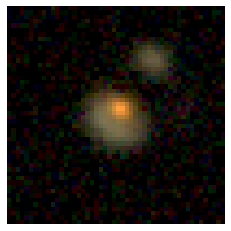

In [13]:
img=sls.showplot_rgb(MLS_I['simulation'],MLS_R['simulation'],MLS_G['simulation'])
plt.imshow(img,origin='lower')
plt.axis(False)
plt.show()